In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import MLP, Layer, Neuron

In [25]:
np.random.seed(1337)
random.seed(1337)

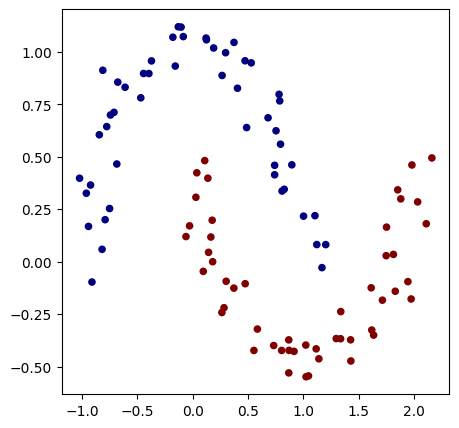

In [26]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

# to make y in -1 to 1
y = y*2-1

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')

In [27]:
# initialize the model
model = MLP(2, [16, 16, 1])
print(model)
print("no. of params", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
no. of params 337


In [28]:
def loss(batch_size=None):
  if batch_size is None:
    Xb, yb = X, y
  else:
    ri = np.random.permutation(X.shape[0])[:batch_size]
    Xb, yb = X[ri], y[ri]
  
  # inputs becomes a list of lists, where each inner list contains Value objects representing the features of one input sample
  inputs = [list(map(Value, xrow)) for xrow in Xb]

  scores = list(map(model, inputs))

  # svm 'max-margin' loss
  losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
  data_loss = sum(losses) * (1.0 / len(losses))

  # regularization (L2)
  alpha = 1e-4
  reg_loss = alpha * sum((p*p for p in model.parameters()))
  total_loss = data_loss + reg_loss

  # for accuracy
  accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
  return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [ ]:
# optimization
for k in range(40):
  # forward
  total_loss, acc = loss()

  # backward
  model.zero_grad()
  total_loss.backward()

  # update
  # lr decay
  lr = 1.0 * 0.9*k/100
  for p in model.parameters():
    p.data -= lr * p.grad

  if k%1 == 0:
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

(-1.548639298268643, 1.951360701731357)

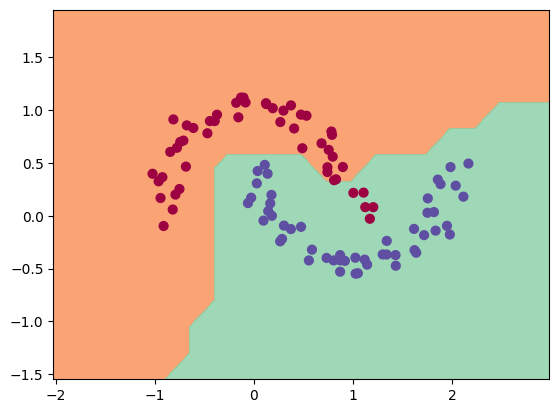

In [30]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())